## VAE

In [1]:
import keras
import numpy as np
import datetime
import tensorflow as tf
import matplotlib.pyplot as plt

from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Conv2D, Flatten, Dense, Conv2DTranspose, Reshape, Lambda, Activation, BatchNormalization, LeakyReLU, Dropout, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras import backend as K
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
from keras.utils import plot_model
from keras import regularizers
from keras.datasets import mnist, fashion_mnist, cifar10

### Conv2d VAE

In [189]:
original_dim = 28 * 28
input_shape = (28, 28, 1)
latent_dim = 2


inputs = Input(shape=input_shape)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(inputs) #28x28
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x) #28x28
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x) #28x28
x = MaxPooling2D((2, 2), padding='same')(x) #14
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x) #14x14
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x) #14x14
x = MaxPooling2D((2, 2), padding='same')(x) #7
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x) #7x7
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x) #7x7
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x) #7x7
x = Flatten()(x) #7 * 7 * 16 = 784

x = Dense(784, activation='relu', activity_regularizer=regularizers.l1(10e-5))(x)
x = Dense(32, activation='relu', activity_regularizer=regularizers.l1(10e-5))(x)

# At this point the representation is (4, 4, 8) == 128
z_mean = Dense(latent_dim)(x)
z_log_sigma = Dense(latent_dim)(x)

def sampling(args):
    z_mean, z_log_sigma = args
    epsilon_shape = (K.shape(z_mean)[0], latent_dim)
    epsilon = K.random_normal(shape=epsilon_shape, mean=0., stddev=0.1)
    return z_mean + K.exp(z_log_sigma) * epsilon

z = Lambda(sampling)([z_mean, z_log_sigma])

# Create encoder
encoder = Model(inputs, [z_mean, z_log_sigma, z], name='encoder')


# Create decoder
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(32, activation='relu', activity_regularizer=regularizers.l1(10e-5))(latent_inputs)
x = Dense(784, activation='relu', activity_regularizer=regularizers.l1(10e-5))(x)

x = Reshape((7, 7, 16))(x) #7x7
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x) #7x7
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x) #7x7
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x) #7x7
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x) #7x7
x = UpSampling2D((2, 2))(x) #14x14
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x) #14x14
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x) #14x14
x = UpSampling2D((2, 2))(x) #28x28
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x) #28x28
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x) #28x28
x = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x) #28x28

decoder = Model(latent_inputs, x, name='decoder')

# instantiate VAE model
outputs = decoder(encoder(inputs)[-1])
vae = Model(inputs, outputs, name='vae_mlp')

dims = 2

In [190]:
# https://machinelearningmastery.com/how-to-implement-major-architecture-innovations-for-convolutional-neural-networks/

def inception_module(layer_in, f1, f2, f3):
    conv1 = Conv2D(f1, (1,1), padding='same', activation='relu')(layer_in)
    conv3 = Conv2D(f2, (3,3), padding='same', activation='relu')(layer_in)
    conv5 = Conv2D(f3, (5,5), padding='same', activation='relu')(layer_in)
    pool = MaxPooling2D((3,3), strides=(1,1), padding='same')(layer_in)
    # concatenate filters, assumes filters/channels last
    layer_out = concatenate([conv1, conv3, conv5, pool], axis=-1)
    return layer_out

def vgg_block(x, n_filters, n_conv, **kwargs):
    for _ in range(n_conv):
        x = Conv2D(n_filters, (3,3), padding='same', activation='relu', **kwargs)(x)
    x = MaxPooling2D((2,2), strides=(2,2))(x)
    return x


In [191]:
# vae.summary()

In [192]:
# vae.layers[1].summary()

In [193]:
# vae.layers[2].summary()

### Loss

In [194]:
from keras.losses import binary_crossentropy

reconstruction_loss = binary_crossentropy(inputs, outputs)
reconstruction_loss = tf.reduce_mean(reconstruction_loss)
reconstruction_loss *= original_dim


kl_loss = 1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma)
kl_loss = K.sum(kl_loss, axis=-1)

kl_beta = 1
kl_loss *= -1 * kl_beta

# mdd loss
# https://github.com/ShengjiaZhao/MMD-Variational-Autoencoder/blob/master/mmd_vae.ipynb
# https://ermongroup.github.io/blog/a-tutorial-on-mmd-variational-autoencoders/
mdd_lambda = 500
def compute_kernel(x, y):
    x_size = tf.shape(x)[0]
    y_size = tf.shape(y)[0]
    dim = tf.shape(x)[1]
    tiled_x = tf.tile(tf.reshape(x, tf.stack([x_size, 1, dim])), tf.stack([1, y_size, 1]))
    tiled_y = tf.tile(tf.reshape(y, tf.stack([1, y_size, dim])), tf.stack([x_size, 1, 1]))
    return tf.exp(-tf.reduce_mean(tf.square(tiled_x - tiled_y), axis=2) / tf.cast(dim, tf.float32))

def compute_mmd(x, y):
    x_kernel = compute_kernel(x, x)
    y_kernel = compute_kernel(y, y)
    xy_kernel = compute_kernel(x, y)
    return tf.reduce_mean(x_kernel) + tf.reduce_mean(y_kernel) - 2 * tf.reduce_mean(xy_kernel)
# Compare the generated z with true samples from a standard Gaussian, and compute their MMD distance
true_samples = K.random_normal(tf.stack([200, latent_dim]))
loss_mmd = compute_mmd(true_samples, z) * mdd_lambda

vae_loss = K.mean(reconstruction_loss + loss_mmd)
vae.add_loss(vae_loss)


vae.compile(optimizer='adam')

In [195]:
loss_mmd, kl_loss, reconstruction_loss

(<KerasTensor: shape=() dtype=float32 (created by layer 'tf.math.multiply_35')>,
 <KerasTensor: shape=(None,) dtype=float32 (created by layer 'tf.math.multiply_33')>,
 <KerasTensor: shape=() dtype=float32 (created by layer 'tf.math.multiply_32')>)

### Data

In [196]:
from string import ascii_uppercase, ascii_lowercase
complete  = '0123456789' + ascii_uppercase + ascii_lowercase
print(complete, len(complete))

def letter_index(letter):
    return complete.index(letter)

def index_letter(index):
    return complete[index]

0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz 62


In [197]:
from extra_keras_datasets import emnist

(X_train, y_train), (X_test, y_test) = emnist.load_data(type='byclass')

X_train = X_train.astype('float32') / 255.
X_test = X_test.astype('float32') / 255.

# if dims == 1:
#     X_train = X_train.reshape((len(X_train), np.prod(X_train.shape[1:])))
#     X_test = X_test.reshape((len(X_test), np.prod(X_test.shape[1:])))
    
X_train.shape, X_test.shape, y_train.shape, y_test.shape

INFO:root:Loading dataset = emnist


((697932, 28, 28), (116323, 28, 28), (697932,), (116323,))

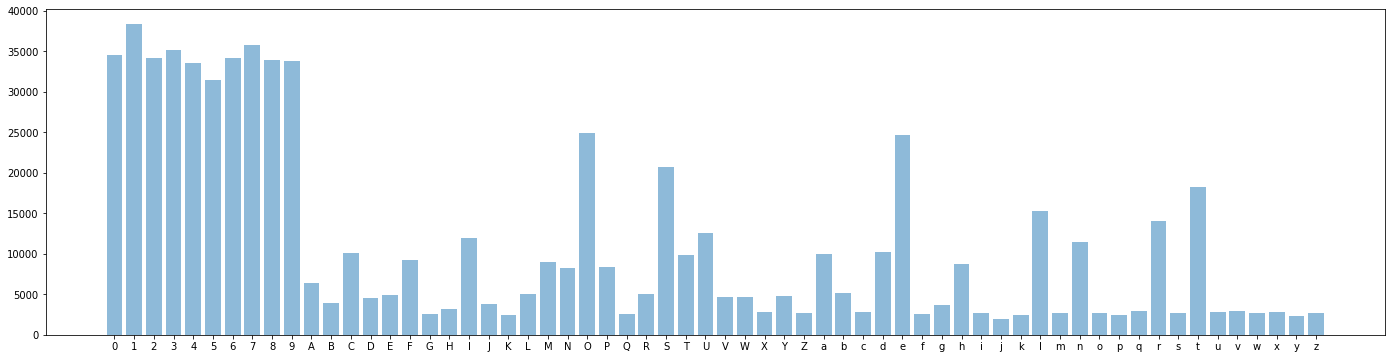

<Figure size 432x288 with 0 Axes>

In [198]:
unique, counts = np.unique(y_train, return_counts=True)
labels = [index_letter(i) for i in unique]
np.asarray((labels, counts)).T

ticks = np.arange(len(labels))
plt.figure(figsize=(24, 6))
plt.bar(ticks, counts, align='center', alpha=0.5)
plt.xticks(ticks, labels)

plt.show()
plt.tight_layout()

In [199]:
y_train = np.array([index_letter(y) for y in y_train])
y_test = np.array([index_letter(y) for y in y_test])

PHRASE = '0123456789Xx'

X_train = X_train[np.isin(y_train, list(PHRASE))]
X_test = X_test[np.isin(y_test, list(PHRASE))]
y_train = y_train[np.isin(y_train, list(PHRASE))]
y_test = y_test[np.isin(y_test, list(PHRASE))]

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((350628, 28, 28), (58820, 28, 28), (350628,), (58820,))

In [186]:
X_google = np.load('C:\\Users\\adamm\\Downloads\\full_numpy_bitmap_angel.npy')
X_google = np.load('C:\\Users\\adamm\\Downloads\\full_numpy_bitmap_sun.npy')
X_google = np.load('C:\\Users\\adamm\\Downloads\\full_numpy_bitmap_smiley face.npy')

nimg, _ = X_google.shape
X_google.resize(nimg, 28, 28)
X_google = X_google.astype('float32') / 255.

dscale = 20
X_google = X_google[:7000*dscale,:]
X_google_train = X_google[:6000*dscale,:]
X_google_test = X_google[6000*dscale:,:]

y_google_train = np.array([10]*X_google_train.shape[0])
y_google_test = np.array([10]*X_google_test.shape[0])


if dims == 2:
    X_train = np.concatenate((X_train, X_google_train), axis=0)
    X_test = np.concatenate((X_test, X_google_test), axis=0)
    y_train = np.concatenate((y_train, y_google_train), axis=0)
    y_test = np.concatenate((y_test, y_google_test), axis=0)
    
if dims == 1:
    X_train = np.vstack((X_train, X_google_train))
    X_test = np.vstack((X_test, X_google_test))
    y_train = np.hstack((y_train, y_google_train))
    y_test = np.hstack((y_test, y_google_test))

if True:
    X_train = X_google_train
    X_test = X_google_test
    y_train = y_google_train
    y_test = y_google_test
    
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((120000, 28, 28), (4386, 28, 28), (120000,), (4386,))

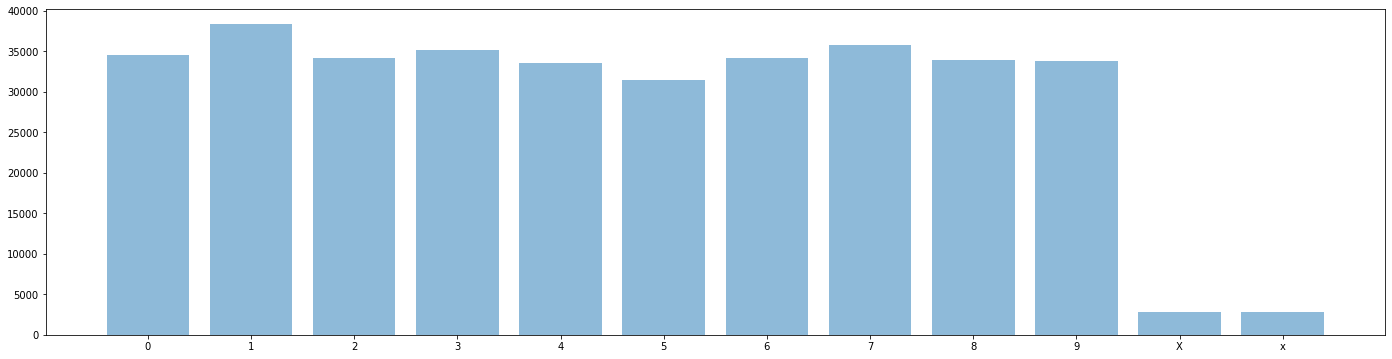

<Figure size 432x288 with 0 Axes>

In [200]:
unique, counts = np.unique(y_train, return_counts=True)
labels = unique

ticks = np.arange(len(labels))
plt.figure(figsize=(24, 6))
plt.bar(ticks, counts, align='center', alpha=0.5)
plt.xticks(ticks, labels)

plt.show()
plt.tight_layout()

In [201]:
import datetime

timestamp = datetime.datetime.utcnow().strftime('%Y%m%d_%H%M%S')

tensorboard = TensorBoard(
    log_dir=f'..\logs\{timestamp}',
    update_freq='epoch',
    embeddings_freq=0,
    embeddings_metadata=None,
    histogram_freq=0,
    write_graph=False,
)
timestamp

'20201226_233733'

In [202]:
import tensorflow_addons as tfa

tqdm_callback = tfa.callbacks.TQDMProgressBar()

tf.config.run_functions_eagerly(True)

vae.fit(
    X_train, X_train,
    epochs=100,
    batch_size=512,
    shuffle=True,
    validation_data=(X_test, X_test),
    verbose=False,
    callbacks=[EarlyStopping(), tqdm_callback],
)
# tensorboard

Epoch 1/100



Epoch 2/100



Epoch 3/100


KeyboardInterrupt: 

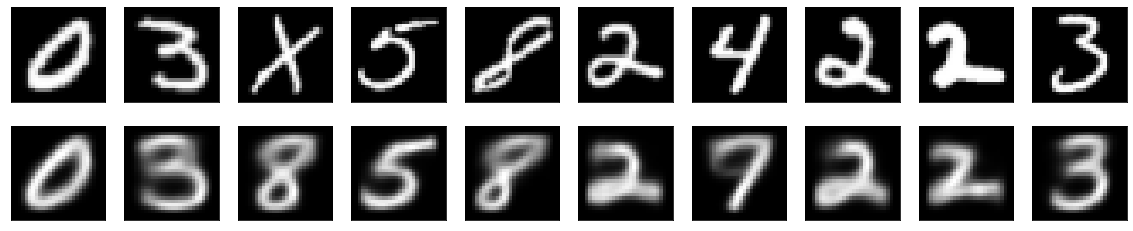

In [203]:
n = 10

decoded_imgs = vae.predict(X_test[:n,:])


plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(X_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [204]:
x_test_encoded = encoder.predict(X_test, batch_size=128)
np.unique(y_test)

array(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'X', 'x'],
      dtype='<U1')

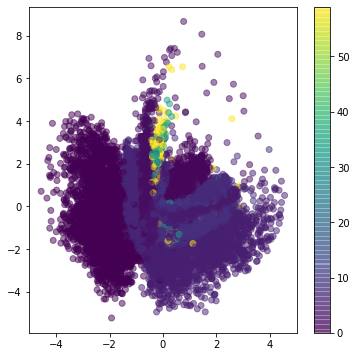

In [205]:
colours = np.array([int(y) if y=='10' else int(letter_index(str(y))) for y in y_test])


plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded[-1][:, 0], x_test_encoded[-1][:, 1], c=colours, cmap='viridis', alpha = 0.5)
plt.colorbar()
plt.show()

In [ ]:
def plot_latent(decoder):
    # display a n*n 2D manifold of digits
    n = 30
    digit_size = 28
    scale = 2.0
    figsize = 15
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = digit

    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range + 1
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="Greys_r")
#     plt.imsave(f'..\latent\mdd\{PHRASE}', figure, format='png')
    plt.show()


plot_latent(decoder)